Resources:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from clean_images import ImageClense
from clean_tabular import TabularCleanse
from PIL import Image
import os
from numpy import asarray
from PIL import UnidentifiedImageError

tabular_cleanse = TabularCleanse('fb_marketplace_conn.json', 'aicore2022!')
# Get and clean image detail data
# img_tabular = tabular_cleanse.get_data_table('images')
img_tabular = pd.read_csv('Images.csv')
img_tabular.drop(['bucket_link',	'image_ref', 'create_time'], axis=1, inplace=True)
# get and trandform image data into arrays
directory = os.path.join(os.getcwd(),'images_fb/clean_images/data/original_256/')
img_list = []
file_names = []
for file in os.listdir(directory):
    try:
        img = Image.open(os.path.join(directory, file))
        img = asarray(img)
    except UnidentifiedImageError:
        img = None
    img_list.append(img)
    file_name = file.replace('.jpg', '')
    file_names.append(file_name)
img_dict = {
    'id': file_names,
    'img_array': img_list
}
img_data = pd.DataFrame(img_dict, columns=['id', 'img_array'])
img_data =  img_data.dropna(subset=['img_array'])
# Create one dataframe for all image data
img_data = pd.merge(img_data, img_tabular, how='left', on='id')
# 62 rows with images in zip file but not in image database - remove these
img_data = img_data.dropna(subset=['product_id'])

Prepare list of products to include in classficiation
###### This is based on the same data included in the tabular classification

In [3]:
# Get product data and transform
products = pd.read_pickle('final_cleaned_products.pkl')
products = products.dropna(subset='long')
products = tabular_cleanse.remove_rows_conditonal(products, 'price_gbp', 1000.00, '<')
products.drop(['location'], axis=1, inplace=True)
# Drop the cat0 fields to test the model
# Consider that dummy encodign has been applied and therefore on of the clasesses is missing.
products = products[products.columns.drop(list(products.filter(regex='cat_1')))]
# This puts category appliances back in as it was removed when cleaning the data using dummy encoding. This was used because i did not want to run the geocoder again due to un time.
categories = list(products.filter(regex='cat_0'))
products['cat_0__Appliances'] = np.where(products[categories].sum(axis=1) == 0, 1, 0)
Applicances = products.pop('cat_0__Appliances')
products.insert(4,'cat_0__Appliances', Applicances)
# summarise count of each catgeory
products.sum()

id                                          243809c0-9cfc-4486-ad12-3b7a16605ba91c58d3f9-8...
price_gbp                                                                            736256.0
long                                                                            344014.976773
lat                                                                             -22414.651779
cat_0__Appliances                                                                         494
cat_0__Baby & Kids Stuff                                                                  392
cat_0__Clothes, Footwear & Accessories                                                    368
cat_0__Computers & Software                                                               547
cat_0__DIY Tools & Materials                                                              505
cat_0__Health & Beauty                                                                    566
cat_0__Home & Garden                                        

#### Create model data
This is one dataset that includes all image and product data that can then be used for image classification

In [4]:
model_data = pd.merge(img_data, products, how='right', left_on='product_id', right_on='id', suffixes=('', '_dupe')).filter(regex='^(?!.*_dupe)')
# model_data.info()
model_data = model_data.dropna(subset=['img_array'])
model_data

,id,img_array,Unnamed: 0,product_id,price_gbp,long,lat,cat_0__Appliances,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,cat_0__Other Goods,"cat_0__Phones, Mobile Phones & Telecoms","cat_0__Sports, Leisure & Travel",cat_0__Video Games & Consoles
0,64aa79f3-e9fa-417c-a332-714b8ce933f1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",665.0,243809c0-9cfc-4486-ad12-3b7a16605ba9,5.0,51.453489,-1.031873,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4e670f9e-7feb-458f-b529-ac52547abe2b,"[[[12, 0, 1], [12, 0, 1], [12, 0, 1], [12, 0, ...",666.0,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0
2,a864ee52-d91e-46e7-94d1-2418e9bb2877,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",667.0,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0
3,bfe77c38-c9eb-47fb-b3d6-31ffdefb6ff9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",668.0,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,20.0,53.150228,0.329093,0,0,0,0,0,0,1,0,0,0,0,0,0
4,a92e56b7-94fc-41b4-ba6c-f2f224f42bb8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",670.0,59948726-29be-4b35-ade5-bb2fd7331856,115.0,51.291949,-2.447623,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11227,99374787-d4b4-4264-980c-954123446777,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",11872.0,88d2d66b-2685-46b8-af84-f495fd2ccb14,380.0,53.450693,-2.994883,0,0,0,0,0,0,0,0,0,0,0,0,1
11228,04722d18-acac-4d7a-8eec-6171c064d382,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",12104.0,8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1
11229,bcc22d62-5285-4fbc-bbe0-d75259dbff71,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",12105.0,8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1
11230,c05faddc-9ae7-4043-8b39-62ff1e3bfcfe,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",12367.0,df8ef910-03cc-4c9e-97a9-7f0a7e838102,10.0,51.272337,-0.721647,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Flatten image arrays
This was completed to simplify the data for training the model

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


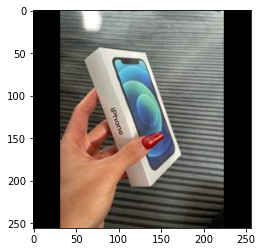

: 

In [5]:
flatten_list = []
for i in model_data['img_array']:
    if type(i) is np.ndarray:
        flatten_list.append(i.flatten())
    else:
        flatten_list.append(None)

model_data['flatten_img_array'] = flatten_list
img = model_data['img_array'].iloc[0]
print(img)
plt.imshow(img)

model_data
pd.to_pickle(model_data, 'image_model_data.pkl')


#### Create X and y data and split data for model training and test

In [16]:
X = model_data['flatten_img_array']
X_unflattened = model_data['img_array']
# print(X_unflattened)
x_numpy = X_unflattened.to_numpy()
print(x_numpy)
print(type(x_numpy))

[array([[[ 3,  0,  0],
         [ 1,  0,  0],
         [ 0,  1,  0],
         ...,
         [ 1,  0,  0],
         [ 0,  2,  5],
         [ 0,  3, 11]],

        [[ 3,  0,  0],
         [ 1,  0,  0],
         [ 0,  1,  0],
         ...,
         [ 1,  0,  0],
         [ 0,  2,  5],
         [ 0,  3, 11]],

        [[ 3,  0,  0],
         [ 1,  0,  0],
         [ 0,  1,  0],
         ...,
         [ 1,  0,  0],
         [ 0,  1,  5],
         [ 0,  3,  9]],

        ...,

        [[ 4,  0,  0],
         [ 3,  0,  0],
         [ 1,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 4,  0,  0],
         [ 3,  0,  0],
         [ 1,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 4,  0,  0],
         [ 3,  0,  0],
         [ 3,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]], dtype=uint8)
 array([[[255, 249, 242],
         [255, 249, 242

In [21]:
from sklearn.preprocessing import LabelEncoder
# The below was used to include variables that were not images - runtime was too high
# X = model_data[['flatten_img_array', 'price_gbp', 'long', 'lat']]
# Create X data to hold image data
X = model_data['flatten_img_array']
X_unflattened = model_data['img_array']
x_numpy = X_unflattened.to_numpy()

np.save('image_model_X_unflatterned.npy', x_numpy)
# pd.to_pickle(X_unflattened, 'image_model_X_unflatterned.pkl')

# pd.to_pickle(X, 'image_model_X.pkl')
X = list(X)

# Create label data - dummy encoding needed to be converted to numerical labels
# Keep only category fields
y = model_data.filter(regex='cat_0')
# intliase LabelEncoder to quickly encode categories to numerical values
le = LabelEncoder()
# Convert dummy encoding back to variables using colunm name
y_labels = y.idxmax(axis=1)
label = list(le.fit_transform(y_labels))
y['category']= label
y['labels'] = y_labels
# Create a category lookup table so that we can refer back to find the Encoding string labels
label_lookup = y[['category', 'labels']].copy()
label_lookup = label_lookup.groupby(['category', 'labels'])['category'].count()
pd.to_pickle(y, 'image_model_label_lookup.pkl')
y = y.filter(regex='category')
y_numpy = y.to_numpy()
np.save('image_model_y.npy', y_numpy)
# pd.to_pickle(y, 'image_model_y.pkl')
y = list(y['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_1051/3862150258.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['category']= label
/tmp/ipykernel_1051/3862150258.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['labels'] = y_labels


#### Intialise the model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial')

#### Perform scaling of the data

In [23]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler to train set - which means it identifies the values for scaling only on the training set and stores this in the scaler
scaler.fit(X_train)
print("Scaler fitted")
# The scaler can now be applied to the train, validation and test sets which holds the info from the train set only
X_train = scaler.transform(X_train)
print("X_train scaled")
X_test = scaler.transform(X_test)
print("X_test scaled")

Scaler fitted
X_train scaled
X_test scaled


#### Train model

In [24]:
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',
                   tol=0.1)

#### Run and assess model performance

In [25]:
y_pred = log_reg.predict(X_test)
# summarize the predicted class
print(y_test[22])
print('Predicted Class: %d' % y_pred[22])

4
Predicted Class: 2


In [26]:
score = log_reg.score(X_test, y_test)
print(score)
print(len(y_test))

0.1914984972091026
2329


In [27]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[19  6 15 24 13  9 18 18 12 12 11  9  5]
 [ 6  6 19 20  8  9 15 16  9  7 12  5 10]
 [ 6  6 32 13 11  9 17  9  8  9  7 10  8]
 [ 9  4 12 78  7  7 17 12 10  5 12 10 12]
 [ 7  2  7 15 20 10 34 19 14  8 11  6 11]
 [12  8 12 20 16 27 25 20 15 10 16 11 13]
 [17 10 15 20 28 15 90 23 31 11 15 10  4]
 [ 4  7 15 21 13  9 29 47 11 14 10  8 12]
 [14  2 18 29 11 15 26 13 34  6 10 17 13]
 [11  4 14 17  9  5 31 18 11 19  9  8 14]
 [11  9 12 10 19 15  5  7  2  7 26  6 11]
 [11  4 12 15 15 13 25  7 14  7  3 26  6]
 [13  5  7 22  7  8 13 16 11  4  8  6 22]]


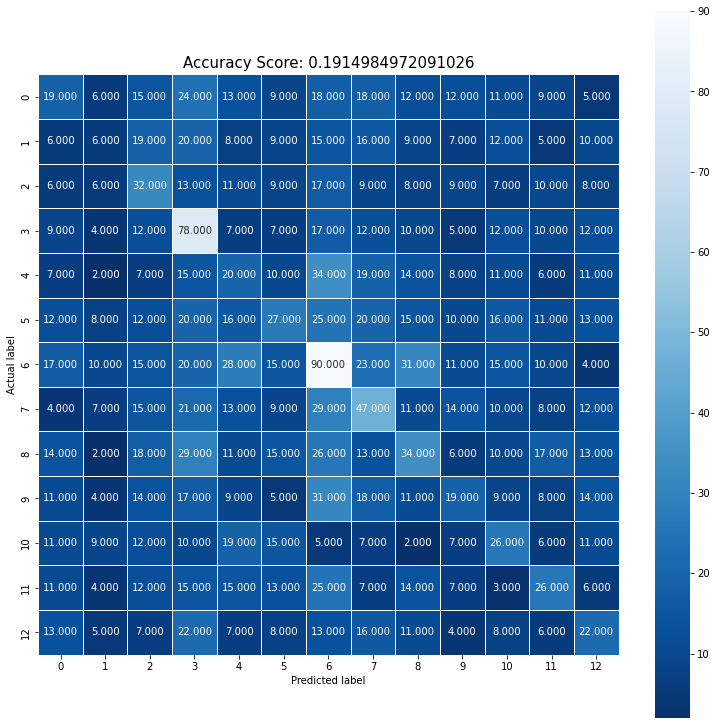

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()

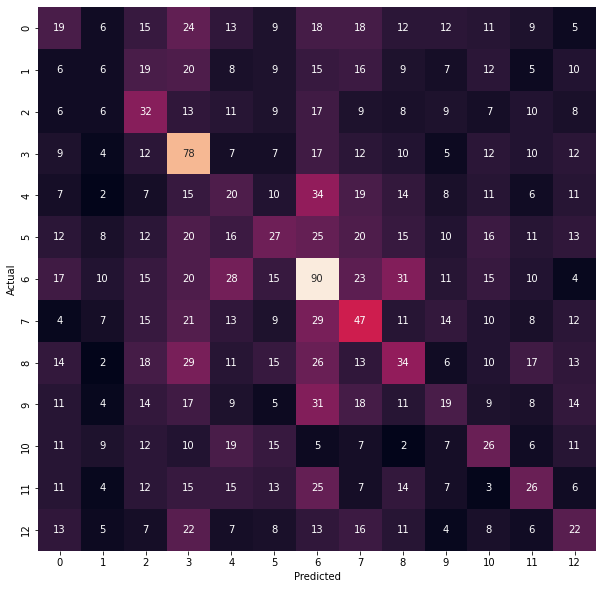

In [29]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'])
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

category  labels                                  
0         cat_0__Appliances                            867
1         cat_0__Baby & Kids Stuff                     682
2         cat_0__Clothes, Footwear & Accessories       691
3         cat_0__Computers & Software                 1003
4         cat_0__DIY Tools & Materials                 871
5         cat_0__Health & Beauty                       999
6         cat_0__Home & Garden                        1409
7         cat_0__Music, Films, Books & Games           987
8         cat_0__Office Furniture & Equipment          981
9         cat_0__Other Goods                           841
10        cat_0__Phones, Mobile Phones & Telecoms      714
11        cat_0__Sports, Leisure & Travel              794
12        cat_0__Video Games & Consoles                804
Name: category, dtype: int64

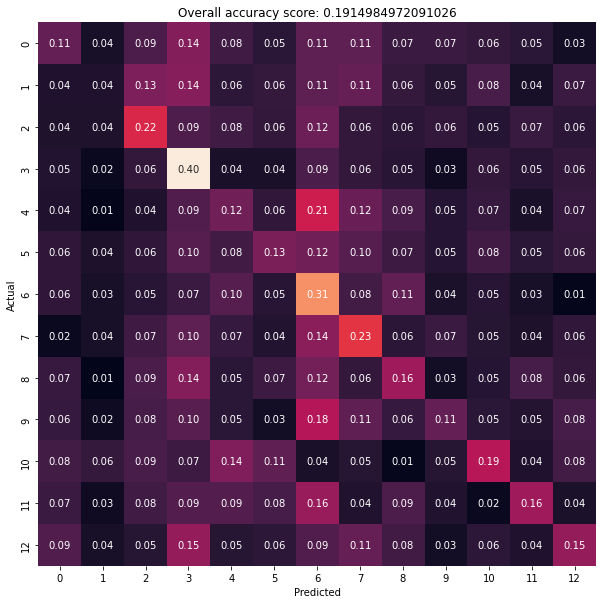

In [30]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)
p.set_title(f'Overall accuracy score: {score}')
label_lookup.head(13)